In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, export_graphviz, export_text
from sklearn.model_selection import GridSearchCV, validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, RocCurveDisplay

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)



--- CART PİPELİNE BAŞLATILDI ---
En İyi Parametreler: {'max_depth': 5, 'min_samples_split': 12}

[CART Classification Report]:
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        82
           1       0.79      0.92      0.85       102

    accuracy                           0.82       184
   macro avg       0.83      0.81      0.81       184
weighted avg       0.83      0.82      0.82       184



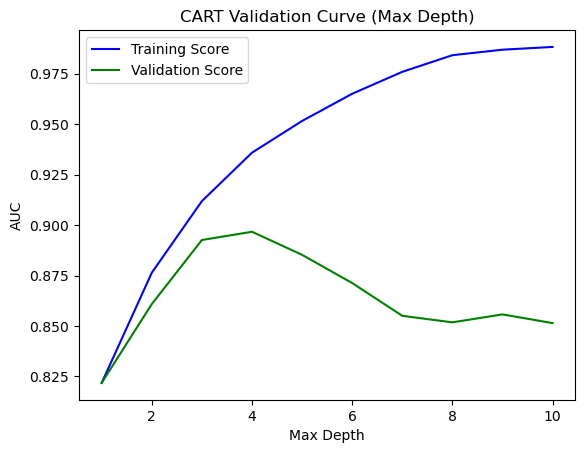


--- KARAR KURALLARI ---
|--- ST_Slope_Up <= 0.50
|   |--- ExerciseAngina_Y <= 0.50
|   |   |--- Age_Oldpeak <= 6.20
|   |   |   |--- RPP <= 206.88
|   |   |   |   |--- RPP <= 116.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- RPP >  116.50
|   |   |   |   |   |--- class: 1
|   |   |   |--- RPP >  206.88
|   |   |   |   |--- class: 1
|   |   |--- Age_Oldpeak >  6.20
|   |   |   |--- RestingBP <= 136.50
|   |   |   |   |--- Sex_M <= 0.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- Sex_M >  0.50
|   


In [3]:
# ==========================================================
# MODÜL 1: DEĞİŞKEN AYRIŞTIRMA (grab_col_names)
# ==========================================================
def grab_col_names(dataframe, cat_th=10, car_th=20):
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]
    return cat_cols, num_cols, cat_but_car

# ==========================================================
# MODÜL 2: ÖZELLİK MÜHENDİSLİĞİ (create_new_features)
# ==========================================================
def create_new_features(df):
    df_new = df.copy()
    
    # 1. Klinik Skorlar ve Etkileşimler
    df_new['RPP'] = (df_new['RestingBP'] * df_new['MaxHR']) / 100
    
    # ExerciseAngina'yı sayısal işleme hazırlama
    angina_map = {'Y': 1, 'N': 0}
    
    # DTS: Duke Treadmill Score Simülasyonu
    df_new['DTS_Simulated'] = 1 - (5 * df_new['Oldpeak']) - (4 * df_new['ExerciseAngina'].map(angina_map))
    
    df_new['HR_Efficiency'] = df_new['MaxHR'] / (220 - df_new['Age'])
    df_new['Age_Oldpeak'] = df_new['Age'] * df_new['Oldpeak']

    # 2. Risk Grupları ve Kategorizasyon
    df_new['HighChol'] = (df_new['Cholesterol'] > 200).astype(int)
    
    # AgeGroup_Optimized: Yaşa dayalı risk segmentasyonu
    df_new['AgeGroup_Optimized'] = pd.cut(
        df_new['Age'], 
        bins=[0, 45, 55, 120], 
        labels=['Young', 'Middle', 'Senior+']
    )
    
    df_new['MetabolicRisk'] = ((df_new['FastingBS'] == 1) & (df_new['HighChol'] == 1)).astype(int)
    
    return df_new

# ==========================================================
# MODÜL 3: VERİ ÖN İŞLEME (Preprocessing & Leakage Protection)
# ==========================================================
def heart_data_prep(X_train, X_test):
    # Train ve Test kopyaları üzerinden işlem yapma
    X_train_prep = X_train.copy()
    X_test_prep = X_test.copy()

    # 1. Hatalı/Eksik Veri İşaretleme
    for df in [X_train_prep, X_test_prep]:
        # Kolesterol 0 değerlerini NaN yap
        df['Cholesterol_Is_Missing'] = (df['Cholesterol'] == 0).astype(int)
        df['Cholesterol'] = df['Cholesterol'].replace(0, np.nan)
        # Kan Basıncı 0 değerlerini NaN yap
        df['RestingBP'] = df['RestingBP'].replace(0, np.nan)

    # 2. Sızıntısız Doldurma (Imputation)
    # Sadece TRAIN setinden istatistikleri alıyoruz
    chol_medians = X_train_prep.groupby('Sex')['Cholesterol'].median()
    bp_median = X_train_prep['RestingBP'].median()

    # Train ve Test setlerini Train'den gelen bilgiyle doldurma
    for gender in ['M', 'F']:
        X_train_prep.loc[(X_train_prep['Sex'] == gender) & (X_train_prep['Cholesterol'].isna()), 'Cholesterol'] = chol_medians[gender]
        X_test_prep.loc[(X_test_prep['Sex'] == gender) & (X_test_prep['Cholesterol'].isna()), 'Cholesterol'] = chol_medians[gender]

    X_train_prep['RestingBP'] = X_train_prep['RestingBP'].fillna(bp_median)
    X_test_prep['RestingBP'] = X_test_prep['RestingBP'].fillna(bp_median)

    # 3. Encoding İşlemi
    # Önce kolonları belirle
    cat_cols, num_cols, cat_but_car = grab_col_names(X_train_prep)
    
    # One-Hot Encoding (Dummies)
    X_train_prep = pd.get_dummies(X_train_prep, columns=cat_cols, drop_first=True)
    X_test_prep = pd.get_dummies(X_test_prep, columns=cat_cols, drop_first=True)

    # Kolon eşitleme (Train'de olup Test'te olmayan kolonları 0 ile doldur)
    X_test_prep = X_test_prep.reindex(columns=X_train_prep.columns, fill_value=0)

    return X_train_prep, X_test_prep

# ==========================================================
# MODÜL 4: FINAL PIPELINE
# ==========================================================
def run_cart_pipeline(df, target="HeartDisease"):
    print("\n--- CART PİPELİNE BAŞLATILDI ---")
    
    # 1. Özellik Mühendisliği (Modül 2)
    df_enriched = create_new_features(df)
    
    # 2. Train-Test Ayırma
    y = df_enriched[target]
    X = df_enriched.drop(target, axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=17)
    
    # 3. Ön İşleme (Modül 3)
    X_train_prep, X_test_prep = heart_data_prep(X_train, X_test)
    
    # 4. Hiperparametre Optimizasyonu (Grid Search)
    cart_model = DecisionTreeClassifier(random_state=17)
    cart_params = {'max_depth': range(1, 11), "min_samples_split": range(2, 20)}
    
    cart_best_grid = GridSearchCV(cart_model, cart_params, cv=5, n_jobs=-1, verbose=0).fit(X_train_prep, y_train)
    print(f"En İyi Parametreler: {cart_best_grid.best_params_}")
    
    # 5. Final Model ve Değerlendirme
    cart_final = cart_model.set_params(**cart_best_grid.best_params_).fit(X_train_prep, y_train)
    y_pred = cart_final.predict(X_test_prep)
    
    print("\n[CART Classification Report]:")
    print(classification_report(y_test, y_pred))
    
    # 6. Model Karmaşıklığı Analizi (Validation Curve)
    train_score, test_score = validation_curve(cart_final, X_train_prep, y_train,
                                               param_name="max_depth", param_range=range(1, 11),
                                               scoring="roc_auc", cv=10)
    
    plt.plot(range(1, 11), np.mean(train_score, axis=1), label="Training Score", color='b')
    plt.plot(range(1, 11), np.mean(test_score, axis=1), label="Validation Score", color='g')
    plt.title("CART Validation Curve (Max Depth)")
    plt.xlabel("Max Depth"); plt.ylabel("AUC"); plt.legend(); plt.show()

    # 7. Karar Kurallarının Çıkarılması
    tree_rules = export_text(cart_final, feature_names=list(X_train_prep.columns))
    print("\n--- KARAR KURALLARI ---")
    print(tree_rules[:500]) # İlk 500 karakteri göster
    
    return cart_final

# ÇALIŞTIRMA:
def load():
    data = pd.read_csv("dataset/heart.csv")
    return data
df = load()
cart_final_model = run_cart_pipeline(df)